In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv

%matplotlib inline

In [86]:
### the model

def sigmoid(x, delta = 1):
    return 1/(1+np.exp(-x/delta))


def GDP(Y, growth = 0.01):
    return Y * (1+growth)

########################### parameters ###########################################################################

default_params = dict()
default_params['growth'] = 0.01 # economic growth
default_params['eps'] = 1 # energy efficiency

default_params['a'] = 1 # Energy production per unit of infrastructure/capital (green)
default_params['b'] = 1 # Energy production per unit of infrastructure/capital (fossil)

default_params['gamma_f'] = 0.2 # Energy price (fossil)
default_params['gamma_g'] = 0.2 # Energy price (green)
default_params['eta_g'] = 0.2 # eta_g*gamma : Costs of energy production (green) [0-1]
default_params['eta_f'] = 0.2 # eta_f*gamma : Costs of energy production (fossil) [0-1]
default_params['h_g'] = 0.5 # Exponent for cost scaling with energy (green) [0-1]
default_params['h_f'] = 0.5 # Exponent for cost scaling with energy (green) [0-1]

default_params['r_inv'] = 0.1 # Fraction of profit that is reinvested in energy infrastructure [0-1]
default_params['beta_0'] = 0.2 # Fraction of infrastructure investments guaranteed for green energy (e.g. subsidies) [0-1]
#default_params['beta_2'] = 0.8 # beta_0 + beta_2 sums to 1
default_params['delta_sig'] = 1

default_params['delta_g'] = 0.005 # Depreciation of infrastructure/capital (green)
default_params['delta_f'] = 0.005 # Depreciation of infrastructure/capital (fossil)

default_params['f_heavy'] = 0.1 # Fraction of total production not willing to go green (e.g. military, heavy industry) [0-1]

#################################################################################################################

def forward_step(Y, Kg, Kf, params = default_params, rule = 'maxgreen', verbose = False):
    success = 0

    #### params ####
    growth = params['growth']
    eps = params['eps']
    a = params['a']
    b = params['b']
    gamma_g = params['gamma_g']
    gamma_f = params['gamma_f']
    eta_g = params['eta_g']
    eta_f = params['eta_f']
    h_g = params['h_g']
    h_f = params['h_f']
    r_inv = params['r_inv']
    beta_0 = params['beta_0']
    delta_sig = params['delta_sig']
    delta_g = params['delta_g']
    delta_f = params['delta_f']
    f_heavy = params['f_heavy']
    #########

    # Energy and infrastructure
    Eg_max = a * Kg # a = 1
    Ef_max = b * Kf # b time dependent, exog. should decrease to 0

    ## Total production?
    # opt 1: exogenous growing Y, tot energy proportional to Y
    E = eps * Y

    if Eg_max + Ef_max < E: 
        success = 2
        print(f'Energy scarcity! {Eg_max} {Ef_max} {E}')
        # raise ValueError(f'Energy scarcity! {Eg_max} {Ef_max} {E}')

    if rule == 'maxgreen':
        Eg = Eg_max
        Ef = E-Eg
        if Eg > E:
            Eg = E
            Ef = 0.
    elif rule == 'proportional':
        Eg = Kg/(Kg+Kf) * E
        Ef = Kf/(Kg+Kf) * E
    elif rule == 'whole_capacity': # This makes Y useless
        Eg = Kg
        Ef = Kf
    elif rule == 'fossil_constraint': # military and heavy industry keep using fossil
        Ef_min = f_heavy * Y
        if E-Ef_min < Eg_max:
            Ef = Ef_min
            Eg = E-Ef_min
        else:
            Eg = Eg_max
            Ef = E-Eg
    
    if E == Eg: 
        print('Transition completed!')
        success = 1

    # opt 2: endogenous Y (Dafermos)
    #Y = l * E_max

    ## Profit of energy production
    Pg = gamma_g * (Eg - eta_g * Eg**h_g)
    Pf = gamma_f * (Ef - eta_f * Ef**h_f)
    if Pf < 0.: Pf = gamma_f * (1 - eta_f) * Ef # linearity for small Ef
    if Pg < 0.: Pg = gamma_g * (1 - eta_g) * Eg # linearity for small Eg

    ## Investment in energy production
    beta_2 = 1 - beta_0 # sums to 1
    beta = (beta_0 + beta_2*sigmoid((Pg/Kg - Pf/Kf)/(Pf/Kf), delta = delta_sig)) # fraction of green investment: should be limited between 0 and 1
    if verbose: print(beta, (Pg/Kg - Pf/Kf)/(Pf/Kf), Eg, Ef, Pg, Pf)
    
    Ig = beta * r_inv * (Pg + Pf)
    If = (1-beta) * r_inv * (Pg + Pf)
    if verbose: print(Ig, If)

    ## for next step
    ## Capital/infrastructure
    if verbose and Ig < Kg*delta_g: print(f'Green infrastructure decreasing! {Ig} < {Kg*delta_g}')
    Kg = Ig + Kg * (1-delta_g)
    if verbose and If < Kf*delta_f: print(f'Fossil infrastructure decreasing! {If} < {Kf*delta_f}')
    Kf = If + Kf * (1-delta_f)
    Y = GDP(Y, growth = growth)

    return Y, Kg, Kf, E, Eg, Ef, success


def run_model(inicond = {'Y_ini' : 1, 'Kg_ini' : 0.1, 'Kf_ini' : 0.9}, params = default_params, n_iter = 100, rule = 'maxgreen', verbose = False):
    Y = inicond['Y_ini']
    Kg = inicond['Kg_ini']
    Kf = inicond['Kf_ini']
    resu = []
    for i in range(n_iter):
        Y, Kg, Kf, E, Eg, Ef, success = forward_step(Y, Kg, Kf, params = params, verbose = verbose, rule = rule)
        resu.append([Y, Kg, Kf, E, Eg, Ef])
        if success == 0: 
            continue
        elif success == 1:
            print(f'Transition completed at time: {i}!')
            break
        elif success == 2:
            print(f'Energy scarcity at time: {i}!')
            break


    return resu

In [3]:
def plot_resu(resu):
    resu = np.stack(resu)
    Ys = resu[:, 0]
    Kgs = resu[:, 1]
    Kfs = resu[:, 2]
    E = resu[:, 3]
    Eg = resu[:, 4]
    Ef = resu[:, 5]

    fig = plt.figure()
    plt.plot(Kfs + Kgs, label = 'Total')
    plt.plot(Kfs, label = 'Fossil')
    plt.plot(Kgs, label = 'Green')
    plt.xlabel('time')
    plt.ylabel('Energy infrastructure')
    plt.legend()

    fig2 = plt.figure()
    plt.plot(E, label = 'Total')
    plt.plot(Ef, label = 'Fossil')
    plt.plot(Eg, label = 'Green')
    plt.xlabel('time')
    plt.ylabel('Energy production')
    plt.legend()

    return

## Example 1: fossil infrastructure dominates at start

In [ ]:
from lib_ecofun import run_model, plot_resu

Transition completed!
Transition completed at time: 287!


/tmp/ipykernel_172898/3510736161.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (beta_0 + beta_2*sigmoid((Pg/Kg - Pf/Kf)/(Pf/Kf))) # fraction of green investment: should be limited between 0 and 1


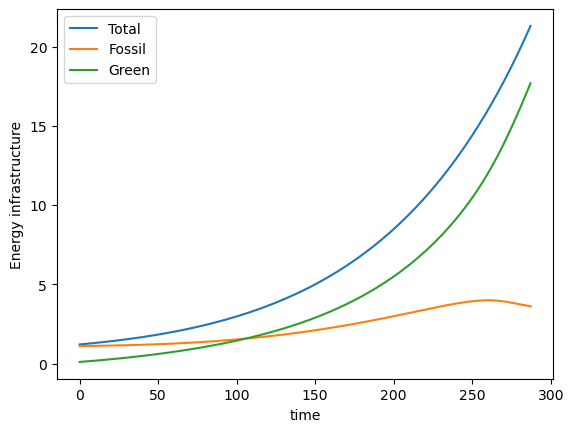

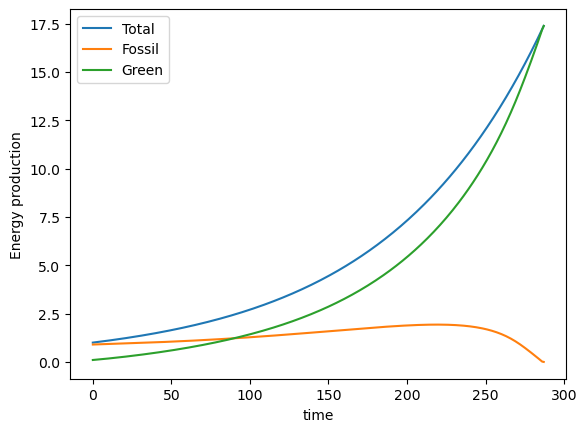

In [19]:
params = default_params.copy()

inicond = {'Y_ini' : 1, 'Kg_ini' : 0.1, 'Kf_ini' : 1.1}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, verbose = False)
plot_resu(resu)


### Same but with fossil constraint

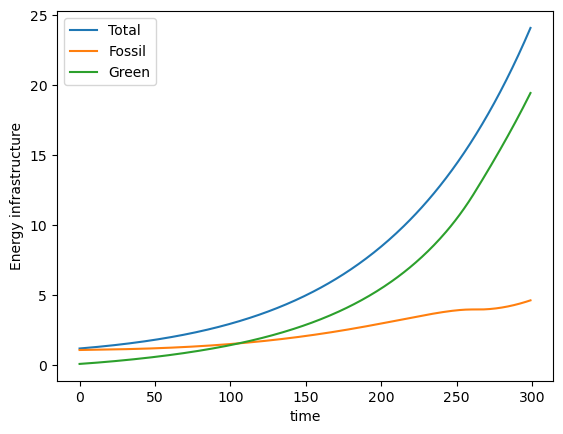

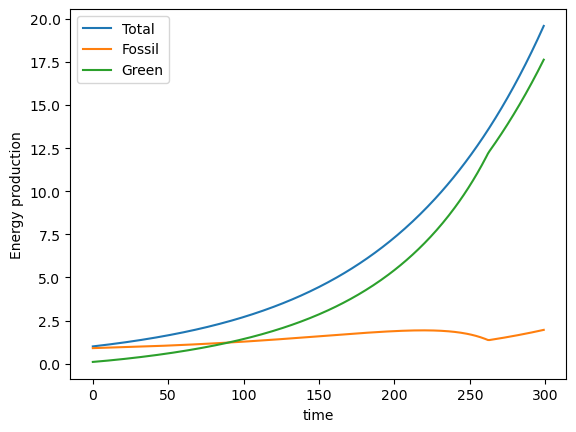

In [5]:
params = default_params.copy()
inicond = {'Y_ini' : 1, 'Kg_ini' : 0.1, 'Kf_ini' : 1.1}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, rule = 'fossil_constraint', verbose = False)
plot_resu(resu)


## Example 2: same starting point

Transition completed!
Transition completed at time: 151!


/tmp/ipykernel_172898/332087353.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (beta_0 + beta_2*sigmoid((Pg/Kg - Pf/Kf)/(Pf/Kf))) # fraction of green investment: should be limited between 0 and 1


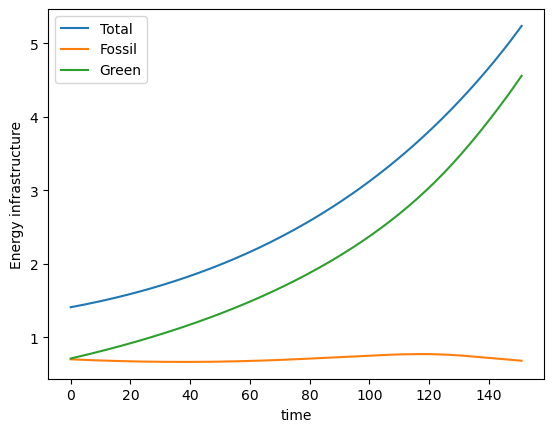

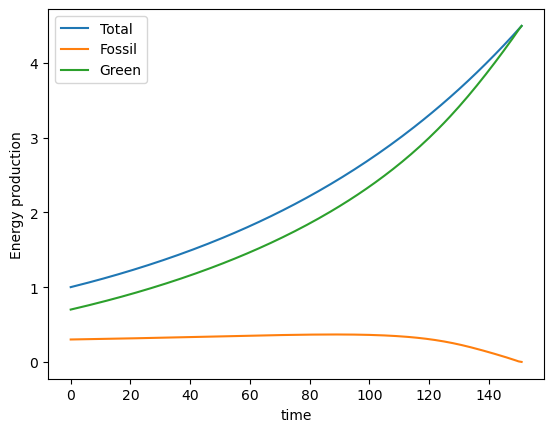

In [6]:
params = default_params.copy()

inicond = {'Y_ini' : 1, 'Kg_ini' : 0.7, 'Kf_ini' : 0.7}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, verbose = False)

plot_resu(resu)


## lower investment

Energy scarcity! 0.5716809057752901 1.6532205851300381 2.238882369366202
Energy scarcity at time: 81!


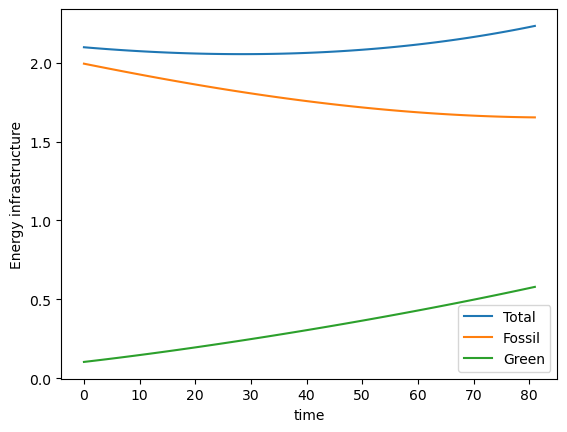

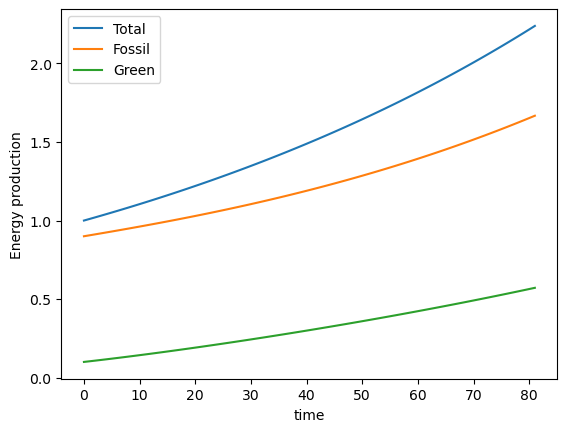

In [15]:
params = default_params.copy()
params['r_inv'] = 0.05

inicond = {'Y_ini' : 1, 'Kg_ini' : 0.1, 'Kf_ini' : 2}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, verbose = False)

plot_resu(resu)


## with degrowth!

Transition completed!
Transition completed at time: 32!


/tmp/ipykernel_172898/3510736161.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (beta_0 + beta_2*sigmoid((Pg/Kg - Pf/Kf)/(Pf/Kf))) # fraction of green investment: should be limited between 0 and 1


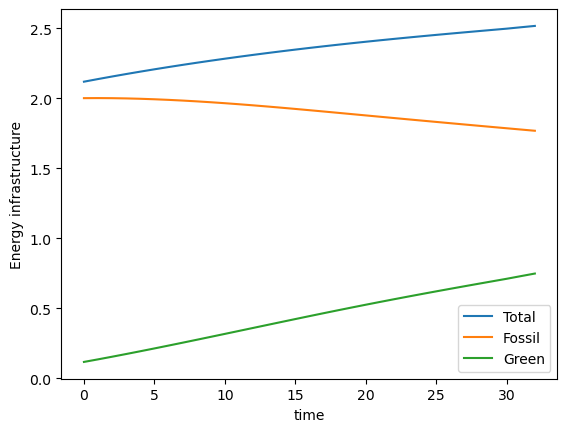

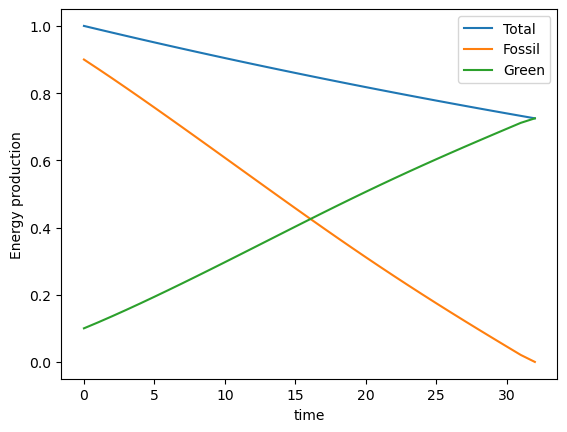

In [17]:
params = default_params.copy()
params['r_inv'] = 0.2
params['growth'] = -0.01

inicond = {'Y_ini' : 1, 'Kg_ini' : 0.1, 'Kf_ini' : 2}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, verbose = False)

plot_resu(resu)


## Some data

In [62]:
## data on investment from IEA (2015 to 2023). https://www.iea.org/reports/world-energy-investment-2023/overview-and-key-findings

lista = '1074 1319 1132 1105 1129 1114 1137 1109 1225 1066 1259 839 1408 914 1617 1002 1740 1050'.split()
Ig_obs_all = np.array(lista[0::2]).astype(float)
If_obs = np.array(lista[1::2]).astype(float)

## Data on green investment for energy production only (only "Renewable power" in clean energy spending)
Ig_obs = np.array('331 340 351 377 451 494 517 596 659'.split()).astype(float)

In [28]:
## E_g/E, from 1965 to 2023 (source ourworldindata: https://ourworldindata.org/renewable-energy)

lista = '6.445519 6.516204 6.423987 6.3901453 6.32996 6.2402315 6.2751184 6.231038 5.98148 6.527657 6.5613737 6.2220235 6.216026 6.4746337 6.5883255 6.8036585 6.9859357 7.1871624 7.3960943 7.3479614 7.309479 7.2850266 7.1429477 7.10847 6.9876184 7.182692 7.301195 7.2864876 7.6539183 7.6321683 7.8718243 7.755703 7.847491 7.890869 7.8530593 7.8158455 7.552836 7.5668545 7.3342075 7.518 7.5638204 7.705343 7.7473364 8.245706 8.564856 8.797048 8.980997 9.414955 9.847355 10.218171 10.504495 10.980251 11.337292 11.743186 12.228147 13.404395 13.469198 14.119935 14.562141'.split()

Eg_ratio = np.array(lista).astype(float)
Eg_ratio_ok = Eg_ratio[-9:]

In [29]:
Eg_ratio_ok

array([10.504495, 10.980251, 11.337292, 11.743186, 12.228147, 13.404395,
       13.469198, 14.119935, 14.562141])

In [34]:
inicond

{'Y_ini': 1, 'Kg_ini': 0.10504495, 'Kf_ini': 0.89495505}

Transition completed!
Transition completed at time: 48!


/tmp/ipykernel_172898/1345106009.py:109: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (beta_0 + beta_2*sigmoid((Pg/Kg - Pf/Kf)/(Pf/Kf), delta = delta_sig)) # fraction of green investment: should be limited between 0 and 1


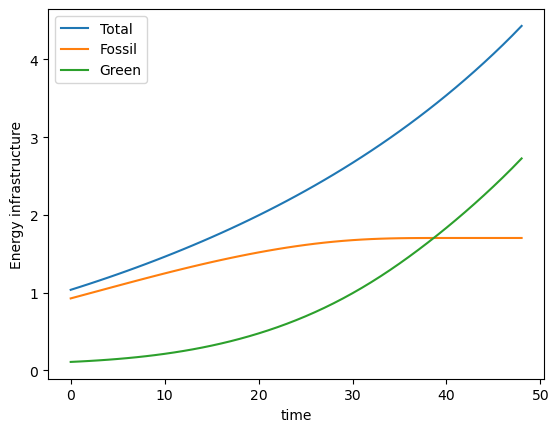

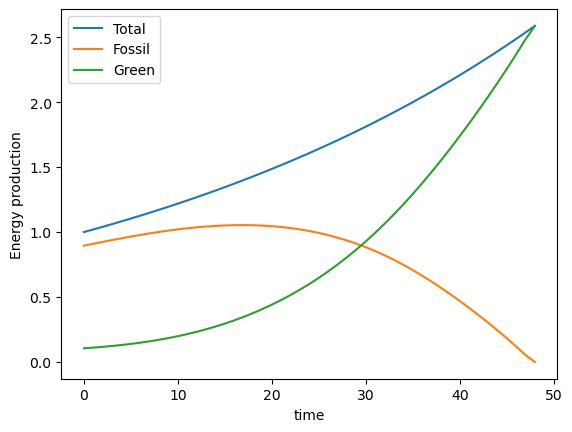

In [147]:
params = default_params.copy()
#params['r_inv'] = 0.2
params['beta_0'] = -0.2
params['delta_sig'] = 0.5
params['gamma_g'] = 0.55
params['gamma_f'] = 0.5

params['growth'] = 0.02
params['delta_g'] = 0.
params['delta_f'] = 0.

inicond = {'Y_ini' : 1, 'Kg_ini' : Eg_ratio_ok[0]/100, 'Kf_ini' : 1-Eg_ratio_ok[0]/100}
n_iter = 300

resu = run_model(inicond = inicond, params = params, n_iter = n_iter, verbose = False)

plot_resu(resu)

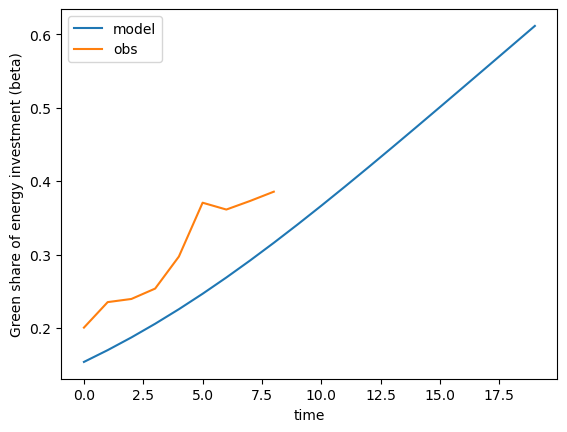

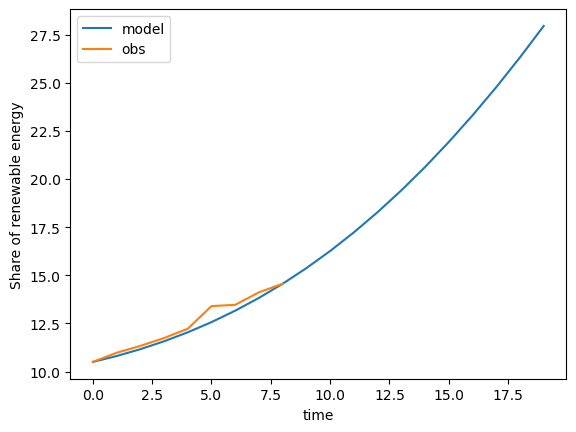

In [148]:
resu = np.stack(resu)
Ys = resu[:, 0]
Kgs = resu[:, 1]
Kfs = resu[:, 2]
E = resu[:, 3]
Eg = resu[:, 4]
Ef = resu[:, 5]

Ig = np.diff(Kgs)
If = np.diff(Kfs)

fig = plt.figure()
plt.plot((Ig/(Ig+If))[:20], label = 'model')
plt.plot(Ig_obs/(Ig_obs+If_obs), label = 'obs')
plt.xlabel('time')
plt.ylabel('Green share of energy investment (beta)')
plt.legend()

fig2 = plt.figure()
plt.plot((100*Eg/E)[:20], label = 'model')
plt.plot(Eg_ratio_ok, label = 'obs')
plt.xlabel('time')
plt.ylabel('Share of renewable energy')
plt.legend()
